Instagram fitness-related interactions vs Apple Watch workouts

Exploring the relationship between my daily Instagram activity and physical exercise levels using my Apple Watch fitness data to understand how social media activity effects my body image expectations.

In [34]:
#import part
from pathlib import Path
from datetime import datetime, timezone
import json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import re

#givinig the directory paths
BASE_DIR = Path("..").resolve()
print("BASE_DIR:", BASE_DIR)
DATA_MANUAL = BASE_DIR / "data_manual"
print("DATA_MANUAL:", DATA_MANUAL, "exists:", DATA_MANUAL.exists())
LIKED_JSON  = DATA_MANUAL / "liked_posts.json"
SAVED_JSON  = DATA_MANUAL / "saved_posts.json"

# asked chatgpt how i can get the health data automatically
workout_files = list(DATA_MANUAL.glob("Workouts-*.csv"))
if not workout_files:
    raise FileNotFoundError(
        f"data_manual klasöründe 'Workouts-*.csv' bulunamadı. "
        f"Mevcut dosyalar: {list(DATA_MANUAL.iterdir())}"
    )
WORKOUT_CSV = workout_files[0]
print("Seçilen WORKOUT_CSV:", WORKOUT_CSV)

DAILY_ACTIVITY_CSV = None

# Putting the merged data to the same data folder
OUTPUT_MERGED = DATA_MANUAL / "merged_fitness_workouts_daily.csv"
OUTPUT_MERGED.parent.mkdir(parents=True, exist_ok=True)

print("LIKED_JSON exists:", LIKED_JSON.exists())
print("SAVED_JSON exists:", SAVED_JSON.exists())
print("WORKOUT_CSV exists:", WORKOUT_CSV.exists())
print("DAILY_ACTIVITY_CSV is None:", DAILY_ACTIVITY_CSV is None)

#got help with error messages to see if properly works or not

BASE_DIR: /Users/uveyscoban/DSA210_project
DATA_MANUAL: /Users/uveyscoban/DSA210_project/data_manual exists: True
Seçilen WORKOUT_CSV: /Users/uveyscoban/DSA210_project/data_manual/Workouts-20241123_193300-20251130_193326.csv
LIKED_JSON exists: True
SAVED_JSON exists: True
WORKOUT_CSV exists: True
DAILY_ACTIVITY_CSV is None: True


In [35]:
#helper functions and keywords to see the related keywords and hashtags
FITNESS_KEYWORDS = [
    # English keywords
    "fitness", "fit ", "get fit", "gym", "workout", "work out", "training",
    "strength", "strength training", "powerlifting", "bodybuilding",
    "hiit", "crossfit", "cardio", "lifting", "lift day", "leg day",
    "push day", "pull day", "upper body", "lower body",
    "squat", "deadlift", "bench press", "hip thrust",
    "run ", "running", "runner", "jog", "jogging", "cycling", "spin class",
    "yoga", "pilates", "mobility", "stretching",
    "calorie deficit", "calorie surplus", "cutting", "bulking",
    "macro", "macros", "protein", "high protein", "meal prep",
    "healthy recipe", "healthy eating", "clean eating", "mealplan",

    # Turkish versions of the keywords
    "spor salonu", "spor salon", "spor yap", "spora git", "salona git",
    "fitness salonu", "vücut geliştirme", "vucut geliştirme",
    "ağırlık", "ağırlık çalış", "ağırlık antrenmanı",
    "idman", "antrenman", "antreman", "koç", "pt ", "kişisel antrenör",
    "sağlıklı yaşam", "sağlıklı beslenme", "diyet", "diyetisyen",
    "kalori", "proteinli", "yüksek protein", "fit tarif", "sağlıklı tarif",
]

FITNESS_HASHTAG_KEYWORDS = [
    # English hashtags
    "#fitness", "#fit", "#fitlife", "#fitfam", "#gym", "#gymlife",
    "#workout", "#workoutmotivation", "#training",
    "#strength", "#strengthtraining",
    "#bodybuilding", "#powerlifting", "#hiit", "#crossfit",
    "#run", "#running", "#runner", "#yoga", "#pilates",
    "#health", "#healthy", "#healthylifestyle", "#healthyeating",
    "#mealprep", "#highprotein",
    # Turkish version of the keywords
    "#fitnessmotivation", "#sporsalon", "#sporsalonu",
    "#spor", "#fitvücut", "#fitvucut", "#diyet", "#diyetisyen",
    "#sağlıklıbeslenme", "#sağlıklıyaşam", "#fitol", "#fitkız", "#fitkiz",
]
FITNESS_HANDLE_WHITELIST = set()


# Tried to find accounts with keywords to enhance my results
FITNESS_HANDLE_PATTERNS = [
    "fit", "fitness", "gym", "workout", "lifting", "lifter",
    "powerlift", "bodybuild", "strength", "cardio",
    "run", "runner", "yoga", "pilates",
    "spor", "antrenman", "antreman", "coach", "koç",
]

def ts_to_date(ts):
    """Instagram timestamp -> just the date(UTC)."""
    ts = float(ts)
    if ts > 10**12:  # ms ise
        ts = ts / 1000.0
    return datetime.fromtimestamp(ts, tz=timezone.utc).date()

#part where i am trying to handle the abovementioned hashtags
def is_fitness_text(text: str | None) -> bool:
    if not text:
        return False
    t = text.lower()

    for tag in FITNESS_HASHTAG_KEYWORDS:
        if tag in t:
            return True

    for kw in FITNESS_KEYWORDS:
        if kw in t:
            return True

    pattern = r"(leg|push|pull|upper|lower)\s+day"
    if re.search(pattern, t):
        return True

    return False

def is_fitness_handle(handle: str | None) -> bool:
    if not handle:
        return False
    h = handle.lower()

    if h in FITNESS_HANDLE_WHITELIST:
        return True

    return any(pat in h for pat in FITNESS_HANDLE_PATTERNS)

def is_fitness_from_any(text: str | None = None,
                        handle: str | None = None) -> bool:
    return is_fitness_text(text) or is_fitness_handle(handle)

def duration_to_minutes(s):
    """'HH:MM:SS' -> minutes."""
    parts = str(s).split(":")
    if len(parts) != 3:
        return np.nan
    h, m, sec = map(float, parts)
    return h * 60 + m + sec / 60

In [36]:
#Instagram daily gym content view rate part
from pathlib import Path

def load_events_from_json(path: Path | None, kind: str):
    records = []

    if path is None or (not path.exists()):
        print(f"{kind} JSON not found or None:", path)
        return records

    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    #Asked chatgpt for ideas to how to handle data that comes from likes.json file but used my own approach

    if isinstance(data, dict) and "likes_media_likes" in data:
        items = data["likes_media_likes"]
        for item in items:
            sld = item.get("string_list_data", [])
            if not sld:
                continue
            entry = sld[0]
            ts = entry.get("timestamp")
            text = entry.get("value", "")
            handle = item.get("title", "")
            if ts is None:
                continue
            day = ts_to_date(ts)
            records.append({
                "date": day,
                "kind": kind,
                "is_fitness": int(is_fitness_from_any(text=text, handle=handle)),
                "has_any_text": int(bool(text)),
            })
        print(f"{kind} events loaded (likes_media_likes schema):", len(records))
        return records

    
    if isinstance(data, dict):
        first_key = list(data.keys())[0]
        items = data[first_key]
    else:
        items = data

    for item in items:
        ts = None
        text = None
        handle = item.get("title")

        if "string_map_data" in item:
            smd = item["string_map_data"]
            if "Time" in smd:
                ts = smd["Time"].get("timestamp")
            # caption vb.
            for k in ["Media title", "Media caption", "Caption", "Title"]:
                if k in smd and smd[k].get("value"):
                    text = smd[k]["value"]

        if ts is None and "string_list_data" in item:
            sld = item["string_list_data"]
            if isinstance(sld, list) and sld:
                ts = sld[0].get("timestamp", ts)
                if text is None:
                    text = sld[0].get("value")

        if ts is None:
            continue

        day = ts_to_date(ts)
        records.append({
            "date": day,
            "kind": kind,
            "is_fitness": int(is_fitness_from_any(text=text, handle=handle)),
            "has_any_text": int(bool(text)),
        })

    print(f"{kind} events loaded (generic schema):", len(records))
    return records


# dataframe wehre i hande likes and saves
like_records = load_events_from_json(LIKED_JSON, "like")
save_records = load_events_from_json(SAVED_JSON, "save")

all_events = like_records + save_records
df_events = pd.DataFrame(all_events)
print("Toplam IG events:", len(df_events))

if df_events.empty:
    # boşsa bile kolon yapısını koru
    df_fitness_daily = pd.DataFrame(
        columns=[
            "date",
            "total_like","total_save",
            "fitness_like","fitness_save",
            "fitness_total","total_like_save",
            "fitness_share_likesaves",
        ]
    )
else:
    df_fitness_daily = (
        df_events
        .groupby(["date", "kind"], as_index=False)
        .agg(
            total=("is_fitness", "count"),
            fitness=("is_fitness", "sum"),
            with_text=("has_any_text", "sum"),
        )
    )

    df_fitness_daily = df_fitness_daily.pivot(
        index="date", columns="kind", values=["total", "fitness"]
    ).fillna(0)

    # (metric, kind) -> "kind_metric" (ör. "like_total")
    df_fitness_daily.columns = [
        f"{kind}_{metric}" for (metric, kind) in df_fitness_daily.columns.to_flat_index()
    ]
    df_fitness_daily = df_fitness_daily.reset_index()

    # Tried to standartize the names
    rename_map = {}
    if "like_total" in df_fitness_daily.columns:
        rename_map["like_total"] = "total_like"
    if "save_total" in df_fitness_daily.columns:
        rename_map["save_total"] = "total_save"
    if "like_fitness" in df_fitness_daily.columns:
        rename_map["like_fitness"] = "fitness_like"
    if "save_fitness" in df_fitness_daily.columns:
        rename_map["save_fitness"] = "fitness_save"

    df_fitness_daily = df_fitness_daily.rename(columns=rename_map)

    # 0 for NA
    for col in ["total_like","total_save","fitness_like","fitness_save"]:
        if col not in df_fitness_daily.columns:
            df_fitness_daily[col] = 0

    df_fitness_daily["fitness_total"] = (
        df_fitness_daily["fitness_like"] + df_fitness_daily["fitness_save"]
    )
    df_fitness_daily["total_like_save"] = (
        df_fitness_daily["total_like"] + df_fitness_daily["total_save"]
    )

    df_fitness_daily["fitness_share_likesaves"] = np.where(
        df_fitness_daily["total_like_save"] > 0,
        df_fitness_daily["fitness_total"] / df_fitness_daily["total_like_save"],
        0,
    )

print("\ndf_fitness_daily ilk satırlar:")
print(
    df_fitness_daily[[
        "date","total_like","total_save",
        "fitness_like","fitness_save",
        "fitness_total","total_like_save","fitness_share_likesaves"
    ]].head(10)
)

like events loaded (likes_media_likes schema): 12641
save events loaded (generic schema): 0
Toplam IG events: 12641

df_fitness_daily ilk satırlar:
         date  total_like  total_save  fitness_like  fitness_save  \
0  2024-11-29          27           0             1             0   
1  2024-11-30          51           0             0             0   
2  2024-12-01          32           0             0             0   
3  2024-12-02          34           0             0             0   
4  2024-12-03          58           0             0             0   
5  2024-12-04          59           0             0             0   
6  2024-12-05          29           0             1             0   
7  2024-12-06          22           0             0             0   
8  2024-12-07          34           0             0             0   
9  2024-12-08          23           0             0             0   

   fitness_total  total_like_save  fitness_share_likesaves  
0              1               

In [37]:
#part where i hande the workout data holding only the date and converting the time to minutes
df_w = pd.read_csv(WORKOUT_CSV)

# looking for the date column wrt only date
df_w["Start_datetime"] = pd.to_datetime(df_w["Start"])
df_w["date"] = df_w["Start_datetime"].dt.date

# Converting time to minutes
df_w["Duration_minutes"] = df_w["Duration"].apply(duration_to_minutes)

# Daily total info regarding the workout
df_workouts_daily = (
    df_w.groupby("date", as_index=False)
        .agg(
            total_workout_minutes=("Duration_minutes", "sum"),
            active_energy_total=("Active Energy (kcal)", "sum"),
            resting_energy_total=("Resting Energy (kcal)", "sum"),
            avg_heart_rate=("Avg. Heart Rate (count/min)", "mean"),
            max_heart_rate=("Max. Heart Rate (count/min)", "max"),
            intensity_avg=("Intensity (kcal/hr·kg)", "mean"),
            step_count_total=("Step Count", "sum"),
        )
)

df_workouts_daily["workout_done"] = np.where(
    df_workouts_daily["total_workout_minutes"] > 0, 1, 0
)
#some example days coming from the first rows
print(df_workouts_daily.head())

         date  total_workout_minutes  active_energy_total  \
0  2024-11-25              84.183333           563.204111   
1  2024-11-26             108.466667           645.573428   
2  2024-11-29             106.650000           622.402402   
3  2024-12-02              78.016667           476.337000   
4  2024-12-05              90.783333           620.700059   

   resting_energy_total  avg_heart_rate  max_heart_rate  intensity_avg  \
0              3.690288      111.978382           158.0       5.137116   
1            773.712549       93.435283           153.0       3.147509   
2            619.950733      102.954042           157.0       5.181471   
3              6.945074      111.637954           151.0       4.524965   
4             64.683597      137.293178           168.0       6.004513   

   step_count_total  workout_done  
0       2276.756913             1  
1       3743.138338             1  
2       3125.975977             1  
3       2335.346310             1  
4       

In [38]:
# Merging the matching data from workout and insta here
min_date = min(df_fitness_daily["date"].min(), df_workouts_daily["date"].min())
max_date = max(df_fitness_daily["date"].max(), df_workouts_daily["date"].max())

calendar = pd.DataFrame({
    "date": pd.date_range(start=min_date, end=max_date, freq="D").date
})
print("Total days", len(calendar))

# Trying to match the dates, looked through different websites
df_fitness_daily["date"] = pd.to_datetime(df_fitness_daily["date"]).dt.date
df_workouts_daily["date"] = pd.to_datetime(df_workouts_daily["date"]).dt.date

df_all = (
    calendar
    .merge(df_fitness_daily, on="date", how="left")
    .merge(df_workouts_daily, on="date", how="left")
)

#essential bc i had to make the NA values 0
for col in [
    "total_like","total_save","fitness_like","fitness_save",
    "fitness_total","total_like_save","fitness_share_likesaves",
    "total_workout_minutes","active_energy_total","resting_energy_total",
    "avg_heart_rate","max_heart_rate","intensity_avg","step_count_total",
    "workout_done",
]:
    if col in df_all.columns:
        df_all[col] = df_all[col].fillna(0)

print("\nMerged dataset with calendar (first rows):")
print(df_all.head())

print("\nTotal days:", len(df_all))
print("Workout days:", int((df_all["workout_done"] == 1).sum()))
print("Rest days:", int((df_all["workout_done"] == 0).sum()))

df_all.to_csv(OUTPUT_MERGED, index=False)
print("\nMerged dataset saved to:", OUTPUT_MERGED)

Total days 370

Merged dataset with calendar (first rows):
         date  total_like  fitness_like  total_save  fitness_save  \
0  2024-11-25         0.0           0.0         0.0           0.0   
1  2024-11-26         0.0           0.0         0.0           0.0   
2  2024-11-27         0.0           0.0         0.0           0.0   
3  2024-11-28         0.0           0.0         0.0           0.0   
4  2024-11-29        27.0           1.0         0.0           0.0   

   fitness_total  total_like_save  fitness_share_likesaves  \
0            0.0              0.0                 0.000000   
1            0.0              0.0                 0.000000   
2            0.0              0.0                 0.000000   
3            0.0              0.0                 0.000000   
4            1.0             27.0                 0.037037   

   total_workout_minutes  active_energy_total  resting_energy_total  \
0              84.183333           563.204111              3.690288   
1          

Workout gün sayısı: 140
Rest (no workout) gün sayısı: 230
Varyans (workout days, fitness_total): 0.4930626927029803
Varyans (rest days, fitness_total): 0.30727169166508445

Welch t-test (fitness_total: workout vs rest)
t-statistic: 1.1183976224896688 p-value: 0.2645006366028729

Mann-Whitney U test (fitness_total: workout vs rest)
U-statistic: 16656.0 p-value: 0.4263225617279085

Merged dataset saved to: /Users/uveyscoban/DSA210_project/data_manual/merged_fitness_workouts_daily.csv

Summary of total_like_save:
count    370.000000
mean      34.164865
std       33.467978
min        0.000000
25%       11.000000
50%       26.000000
75%       46.000000
max      239.000000
Name: total_like_save, dtype: float64

total_like_save - workout vs rest:
Days w workout: 140
Rest days: 230
Mean (workout): 38.114285714285714
Mean (rest):    31.76086956521739
Var (workout): 1154.432887975334
Var (rest):    1088.820296183786

Welch t-test (total_like_save: workout vs rest)
t-statistic: 1.763480999109913 

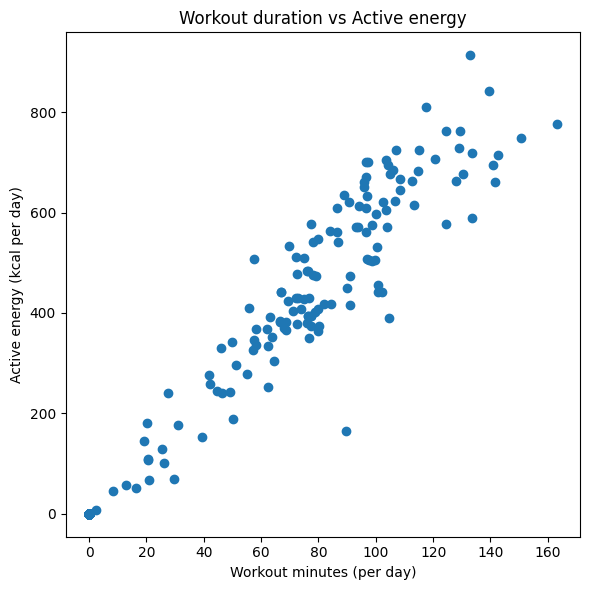


Correlation: total_workout_minutes vs step_count_total
r = 0.8388852058369122 p-value = 3.0583916628857065e-99
Correlation (ALL days): fitness_total vs total_workout_minutes
r = 0.04740597714046386 p-value = 0.36319281934625486


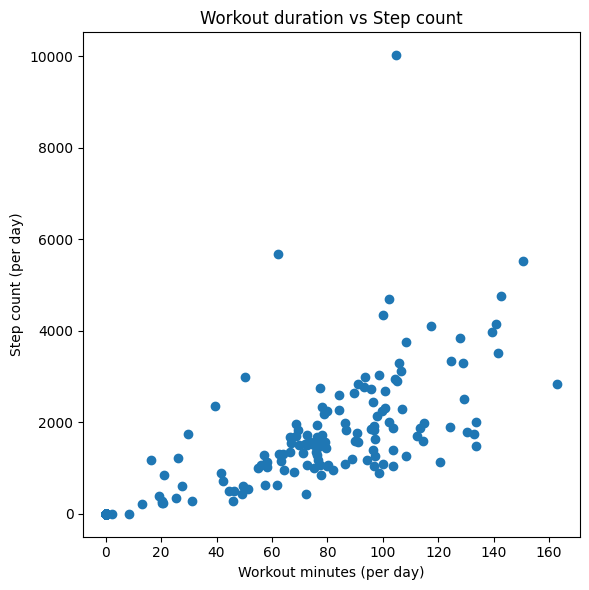

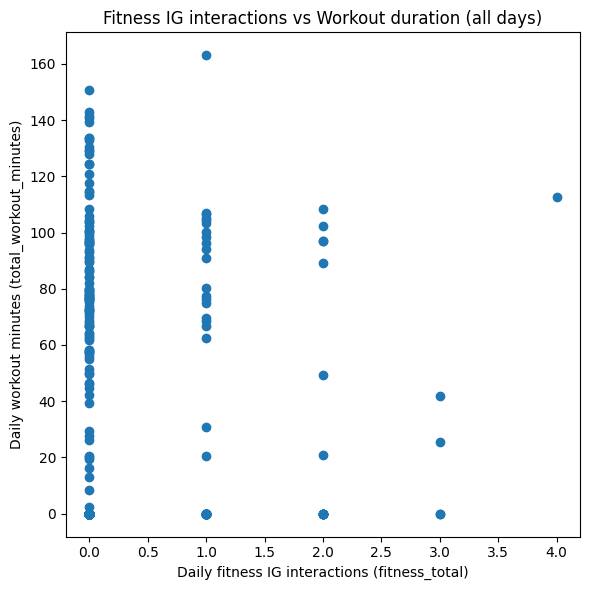


Correlation (IG activity days only): fitness_total vs total_workout_minutes
r = 0.04949939978044254 p-value = 0.3470051883216758


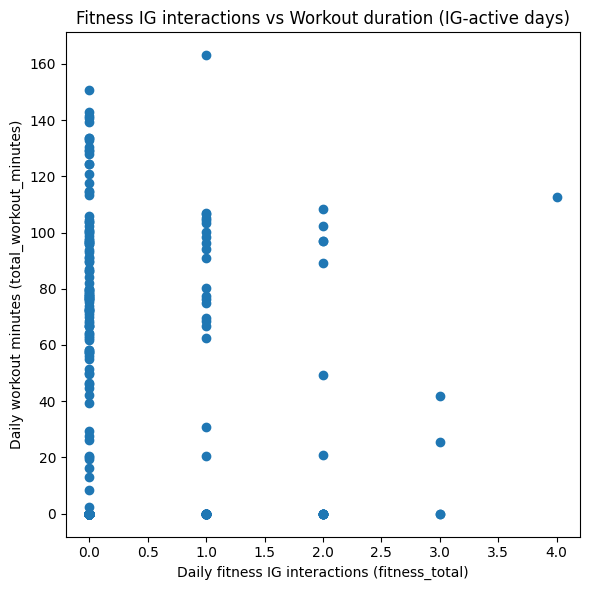

In [39]:
#tried to find a corelation by comparing the days with and without workout
workout_days = df_all[df_all["workout_done"] == 1]["fitness_total"]
rest_days    = df_all[df_all["workout_done"] == 0]["fitness_total"]

print("Workout gün sayısı:", len(workout_days))
print("Rest (no workout) gün sayısı:", len(rest_days))
print("Varyans (workout days, fitness_total):", workout_days.var(ddof=1))
print("Varyans (rest days, fitness_total):", rest_days.var(ddof=1))

# Asked chatgpt for the smartest appoarch and used Welch t-test, Mann-Whitney test repsectively
t_stat, p_val = stats.ttest_ind(
    workout_days, rest_days, equal_var=False
)

print("\nWelch t-test (fitness_total: workout vs rest)")
print("t-statistic:", t_stat, "p-value:", p_val)

u_stat, p_u = stats.mannwhitneyu(
    workout_days, rest_days, alternative="two-sided"
)
print("\nMann-Whitney U test (fitness_total: workout vs rest)")
print("U-statistic:", u_stat, "p-value:", p_u)

df_all.to_csv(OUTPUT_MERGED, index=False)
print("\nMerged dataset saved to:", OUTPUT_MERGED)

#tried to enhance the correlation by seeing the instagram impressions for the days with and without workout
print("\nSummary of total_like_save:")
print(df_all["total_like_save"].describe())

likes_on_workout = df_all[df_all["workout_done"] == 1]["total_like_save"]
likes_on_rest    = df_all[df_all["workout_done"] == 0]["total_like_save"]

print("\ntotal_like_save - workout vs rest:")
print("Days w workout:", len(likes_on_workout))
print("Rest days:", len(likes_on_rest))
print("Mean (workout):", likes_on_workout.mean())
print("Mean (rest):   ", likes_on_rest.mean())
print("Var (workout):", likes_on_workout.var(ddof=1))
print("Var (rest):   ", likes_on_rest.var(ddof=1))

t2, p2 = stats.ttest_ind(likes_on_workout, likes_on_rest, equal_var=False)
print("\nWelch t-test (total_like_save: workout vs rest)")
print("t-statistic:", t2, "p-value:", p2)

u2, p_u2 = stats.mannwhitneyu(likes_on_workout, likes_on_rest, alternative="two-sided")
print("\nMann-Whitney U (total_like_save: workout vs rest)")
print("U-statistic:", u2, "p-value:", p_u2)

#additional correlations that i have tried to find between wrkout minutes and energy/steps 

x_minutes = df_all["total_workout_minutes"].fillna(0)
y_energy  = df_all["active_energy_total"].fillna(0)
y_steps   = df_all["step_count_total"].fillna(0)

print("\nCorrelation: total_workout_minutes vs active_energy_total")
r1, p1 = stats.pearsonr(x_minutes, y_energy)
print("r =", r1, "p-value =", p1)

plt.figure(figsize=(6, 6))
plt.scatter(x_minutes, y_energy)
plt.xlabel("Workout minutes (per day)")
plt.ylabel("Active energy (kcal per day)")
plt.title("Workout duration vs Active energy")
plt.tight_layout()
plt.show()

print("\nCorrelation: total_workout_minutes vs step_count_total")
r2, p2 = stats.pearsonr(x_minutes, y_steps)
print("r =", r2, "p-value =", p2)

plt.figure(figsize=(6, 6))
plt.scatter(x_minutes, y_steps)
plt.xlabel("Workout minutes (per day)")
plt.ylabel("Step count (per day)")
plt.title("Workout duration vs Step count")
plt.tight_layout()
plt.show

# ================================
# PART 5D – Same-day correlation:
# fitness_total vs total_workout_minutes
# ================================

# İki şekilde yapabiliriz:
# 1) Tüm günler (fitness_total 0 olsa bile)
# 2) Sadece IG'de en az 1 etkileşimin olduğu günler
# Ben ikisini de veriyorum.

# --- 1) Tüm günler ---
x_all = df_all["fitness_total"].fillna(0)
y_all = df_all["total_workout_minutes"].fillna(0)

r_all, p_all = stats.pearsonr(x_all, y_all)
print("Correlation (ALL days): fitness_total vs total_workout_minutes")
print("r =", r_all, "p-value =", p_all)

plt.figure(figsize=(6, 6))
plt.scatter(x_all, y_all)
plt.xlabel("Daily fitness IG interactions (fitness_total)")
plt.ylabel("Daily workout minutes (total_workout_minutes)")
plt.title("Fitness IG interactions vs Workout duration (all days)")
plt.tight_layout()
plt.show()

# --- 2) Sadece IG'de en az 1 etkileşim olan günler ---
mask = df_all["total_like_save"] > 0
x_nonzero = df_all.loc[mask, "fitness_total"]
y_nonzero = df_all.loc[mask, "total_workout_minutes"]

if len(x_nonzero) > 2 and x_nonzero.nunique() > 1:
    r_nz, p_nz = stats.pearsonr(x_nonzero, y_nonzero)
    print("\nCorrelation (IG activity days only): fitness_total vs total_workout_minutes")
    print("r =", r_nz, "p-value =", p_nz)

    plt.figure(figsize=(6, 6))
    plt.scatter(x_nonzero, y_nonzero)
    plt.xlabel("Daily fitness IG interactions (fitness_total)")
    plt.ylabel("Daily workout minutes (total_workout_minutes)")
    plt.title("Fitness IG interactions vs Workout duration (IG-active days)")
    plt.tight_layout()
    plt.show()
else:
    print("\nIG-active days için korelasyon hesaplamak için yeterli veri yok.")

  fitness_bin  mean_workout  median_workout  count_days
0           0     29.927966            0.00         295
1         1–2     33.742381            0.00          70
2          3+     35.933333           25.45           5


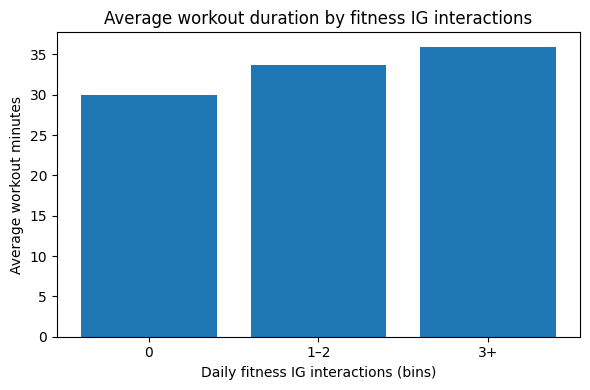

Days with: 295 1 or more with fitness 75
Means: 29.927966101694917 33.888444444444445
Welch t-test (0 vs 1+ fitness): t = -0.6800561394383606 p = 0.49787752850613365
  fitness_bin  p_workout
0           0   0.369492
1         1-2   0.400000
2          3+   0.600000


In [40]:
#Additional part where i have tried to find a negative correlation
df_bins = df_all.copy()

# Categorised based on impression count in 3 sub categories
def fitness_bin(x):
    if x == 0:
        return "0"
    elif x <= 2:
        return "1–2"
    else:
        return "3+"

df_bins["fitness_bin"] = df_bins["fitness_total"].fillna(0).astype(int).map(fitness_bin)

group_stats = (
    df_bins
    .groupby("fitness_bin", as_index=False)
    .agg(
        mean_workout=("total_workout_minutes", "mean"),
        median_workout=("total_workout_minutes", "median"),
        count_days=("date", "count")
    )
    .sort_values("fitness_bin")
)

print(group_stats)

# Using bar plot
plt.figure(figsize=(6,4))
plt.bar(group_stats["fitness_bin"], group_stats["mean_workout"])
plt.xlabel("Daily fitness IG interactions (bins)")
plt.ylabel("Average workout minutes")
plt.title("Average workout duration by fitness IG interactions")
plt.tight_layout()
plt.show()

# t test for days without fitness and one or more fitness
mask_0  = df_all["fitness_total"] == 0
mask_1p = df_all["fitness_total"] >= 1

w0 = df_all.loc[mask_0, "total_workout_minutes"]
w1 = df_all.loc[mask_1p, "total_workout_minutes"]

print("Days with:", len(w0), "1 or more with fitness", len(w1))
print("Means:", w0.mean(), w1.mean())

t, p = stats.ttest_ind(w0, w1, equal_var=False)
print("Welch t-test (0 vs 1+ fitness): t =", t, "p =", p)

bins = [0, 1, 3, 100] 
labels = ["0", "1-2", "3+"]
df_all["fitness_bin"] = pd.cut(
    df_all["fitness_total"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# Additional part with did i workout on that day for each bin
prob_by_bin = (
    df_all
    .groupby("fitness_bin", dropna=False, observed=False)["workout_done"]
    .mean()
    .reset_index(name="p_workout")
)
print(prob_by_bin)